In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

In [2]:
customer = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
customer['SignupDate'] = pd.to_datetime(customer['SignupDate'])

In [4]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [5]:
df = transactions.merge(customer, on="CustomerID").merge(products, on="ProductID")

In [6]:
# Aggregate transaction data per customer
customer_features = df.groupby("CustomerID").agg(
    total_spend=('TotalValue', 'sum'),
    purchase_frequency=('TransactionID', 'count'),
    avg_order_value=('TotalValue', 'mean'),
    unique_products=('ProductID', 'nunique')
).reset_index()

In [7]:
# Convert categorical region into numerical features (one-hot encoding)
region_encoded = pd.get_dummies(customer[['CustomerID', 'Region']], columns=['Region'])

In [8]:
# Merge customer features with encoded regions
customer_profiles = pd.merge(customer_features, region_encoded, on="CustomerID")

In [9]:
scaler = StandardScaler()
numeric_features = ['total_spend', 'purchase_frequency', 'avg_order_value', 'unique_products']
customer_profiles[numeric_features] = scaler.fit_transform(customer_profiles[numeric_features])

c:\Users\Pugazh\anaconda3_1\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Pugazh\anaconda3_1\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Pugazh\anaconda3_1\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pugazh\anaconda3_1\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Pugazh\anaconda3_1\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _w

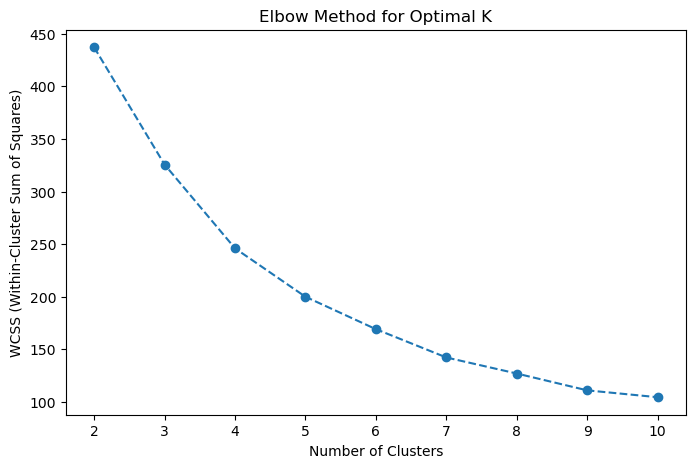

In [10]:
wcss = []
for k in range(2, 11):  # Testing clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_profiles[numeric_features])
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [11]:
optimal_k = 4  # Choose based on elbow method plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_profiles["Cluster"] = kmeans.fit_predict(customer_profiles[numeric_features])

# Compute DB Index
db_index = davies_bouldin_score(customer_profiles[numeric_features], customer_profiles["Cluster"])
print(f"Davies-Bouldin Index: {db_index:.4f}")

Davies-Bouldin Index: 0.8741


c:\Users\Pugazh\anaconda3_1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


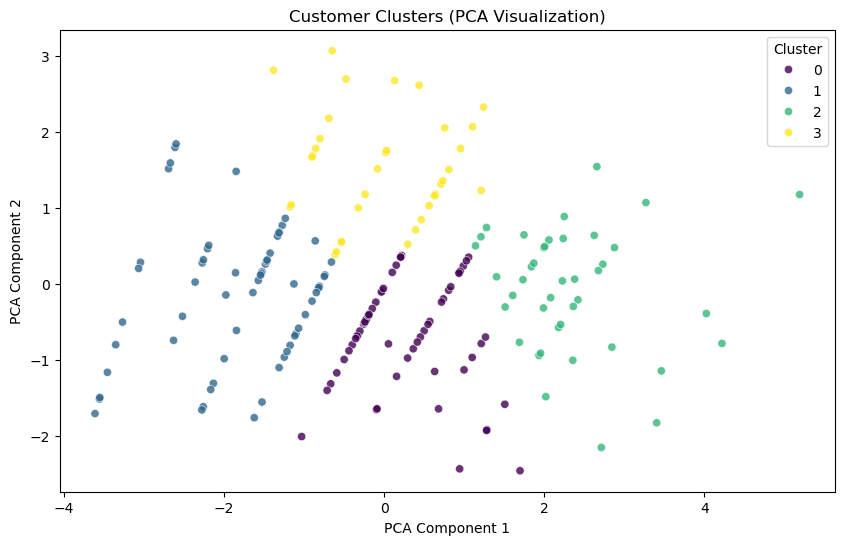

In [12]:
# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
customer_profiles["PCA1"] = pca.fit_transform(customer_profiles[numeric_features])[:, 0]
customer_profiles["PCA2"] = pca.fit_transform(customer_profiles[numeric_features])[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=customer_profiles, palette="viridis", alpha=0.8)
plt.title("Customer Clusters (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [13]:
customer_profiles.to_csv("Customer_Segments.csv", index=False)

In [14]:
customer_profiles.head()

,CustomerID,total_spend,purchase_frequency,avg_order_value,unique_products,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster,PCA1,PCA2
0,C0001,-0.061701,-0.011458,-0.070263,0.050047,False,False,False,True,0,-0.026120,-0.089984
1,C0002,-0.877744,-0.467494,-0.934933,-0.424204,True,False,False,False,1,-1.176683,-0.811218
2,C0003,-0.405857,-0.467494,-0.026271,-0.424204,False,False,False,True,1,-0.741147,0.114500
3,C0004,1.032547,1.356650,-0.076769,1.472798,False,False,False,True,2,2.177198,-0.576544
4,C0005,-0.783929,-0.923530,-0.040028,-0.898455,True,False,False,False,1,-1.486066,0.259063
